In [90]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import pystable

In [91]:
from IPython.display import Image
interact_chart = False

# Get Data

Coinbase data (treated)

In [92]:
coin_df = pd.read_csv('risk_pipeline/outputs/data/ETH-BTC_2022-06-01-00-00_2022-10-31-00-00_600secs_treated.csv', index_col=0)

In [93]:
coin_df.head()

,time,close
0,2022-06-01 00:00:00,0.061110
1,2022-06-01 00:10:00,0.061075
2,2022-06-01 00:20:00,0.060915
3,2022-06-01 00:30:00,0.060985
4,2022-06-01 00:40:00,0.061020


In [94]:
# invert close to match uni v3
coin_df.close = 1/coin_df.close

Uniswap data

In [95]:
uni_df = pd.read_csv('../csv/WBTC-WETH-10.0mTWAP-14881677-to-15864319.csv', index_col=0)

In [96]:
uni_df.head()

,timestamp,twap
0,2022-06-01 00:01:54,16.335589
2,2022-06-01 00:11:54,16.345683
4,2022-06-01 00:21:54,16.351692
10,2022-06-01 00:31:54,16.361773
11,2022-06-01 00:41:54,16.366600


In [97]:
uni_df.reset_index(inplace=True)

# Sanity checks

In [98]:
uni_df[uni_df.twap.isna()]

,index,timestamp,twap


In [99]:
coin_df[coin_df.close.isna()]

,time,close


In [100]:
print('shape:', uni_df.shape)
print('first timestamp:', uni_df.timestamp.min())
print('last timestamp:', uni_df.timestamp.max())

shape: (21883, 3)
first timestamp: 2022-06-01 00:01:54
last timestamp: 2022-10-30 23:01:54


In [101]:
print('shape:', coin_df.shape)
print('first timestamp:', coin_df.time.min())
print('last timestamp:', coin_df.time.max())

shape: (21889, 2)
first timestamp: 2022-06-01 00:00:00
last timestamp: 2022-10-31 00:00:00


# Combine data

In [102]:
df = pd.concat([coin_df.time, coin_df.close, uni_df.twap], axis=1)

In [103]:
df

,time,close,twap
0,2022-06-01 00:00:00,16.363934,16.335589
1,2022-06-01 00:10:00,16.373312,16.345683
2,2022-06-01 00:20:00,16.416318,16.351692
3,2022-06-01 00:30:00,16.397475,16.361773
4,2022-06-01 00:40:00,16.388069,16.366600
...,...,...,...
21884,2022-10-30 23:20:00,12.971010,NaN
21885,2022-10-30 23:30:00,12.965124,NaN
21886,2022-10-30 23:40:00,12.977743,NaN
21887,2022-10-30 23:50:00,12.965964,NaN


In [104]:
# Change column names
df.columns = ['time', 'coin', 'uni']

In [105]:
print('NAs in coinbase column =', df[df.coin.isna()].count()[0])
print('NAs in uniswap column =', df[df.uni.isna()].count()[0])


NAs in coinbase column = 0
NAs in uniswap column = 6


In [106]:
df.dropna(inplace=True)

In [107]:
df

,time,coin,uni
0,2022-06-01 00:00:00,16.363934,16.335589
1,2022-06-01 00:10:00,16.373312,16.345683
2,2022-06-01 00:20:00,16.416318,16.351692
3,2022-06-01 00:30:00,16.397475,16.361773
4,2022-06-01 00:40:00,16.388069,16.366600
...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307
21879,2022-10-30 22:30:00,12.997141,12.995306
21880,2022-10-30 22:40:00,12.990387,12.995304
21881,2022-10-30 22:50:00,12.971851,12.995304


# Analysis

In [108]:
def line_chart(df, title, xcol, ycol, x_title, y_title):
    fig = px.line(df, x=xcol, y=ycol)
    fig.update_layout(title=title)
    fig.update_layout(xaxis_title=x_title, yaxis_title=y_title)
    return fig

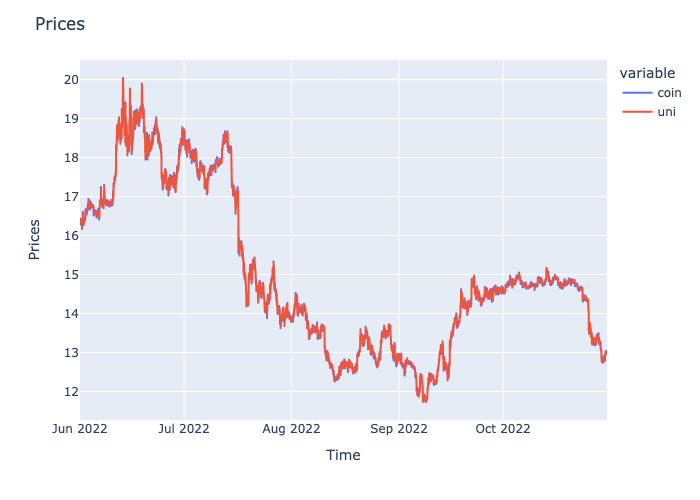

In [109]:
# Superimposed plot
plt = line_chart(df, 'Prices', 'time', ['coin', 'uni'], 'Time', 'Prices')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [110]:
# Pystable funcs

def gaussian():
    return pystable.create(alpha=2.0, beta=0.0, mu=0.0,
                           sigma=1.0, parameterization=1)

def get_qs(dst):
    l = [i/100 for i in range(1, 100, 1)]
    return pystable.q(dst, l, len(l))

def pdf(dst, vals):
    return pystable.pdf(dst, vals, len(vals))

def log_returns(p):
    return [np.log(p[i]/p[i-1]) for i in range(1, len(p))]


In [111]:
# Data funcs
def get_qs_data(series):
    l = [i for i in range(1, 100, 1)]
    return [np.percentile(series, i) for i in l]

In [112]:
log_coin = log_returns(df['coin'])
log_uni = log_returns(df['uni'])

In [113]:
dst_coin = gaussian()
pystable.fit(dst_coin, log_coin, len(log_coin))

dst_uni = gaussian()
pystable.fit(dst_uni, log_uni, len(log_uni))

0

In [114]:
coin_q = get_qs(dst_coin)
uni_q = get_qs(dst_uni)

In [115]:
dist_df = pd.DataFrame(
    {'Percentage': [i/100 for i in range(1, 100, 1)],
     'coin': coin_q, 'uni': uni_q}
)

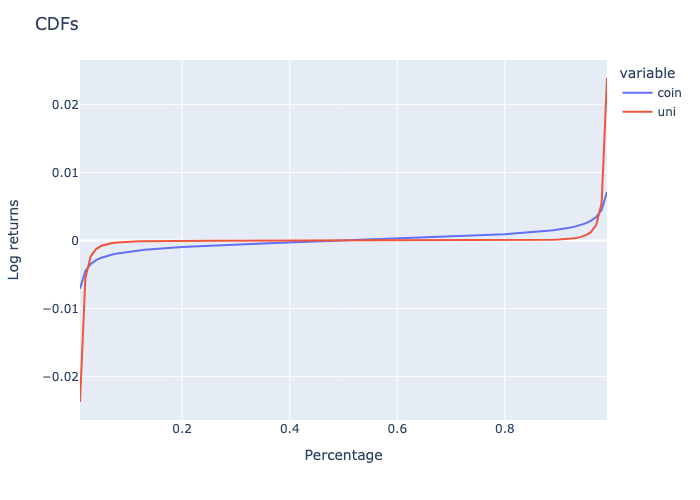

In [116]:
plt = line_chart(dist_df, 'CDFs', 'Percentage', ['coin', 'uni'], 'Percentage', 'Log returns')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [117]:
df['uni_log_returns'] = [0] + log_uni
df['coin_log_returns'] = [0] + log_coin


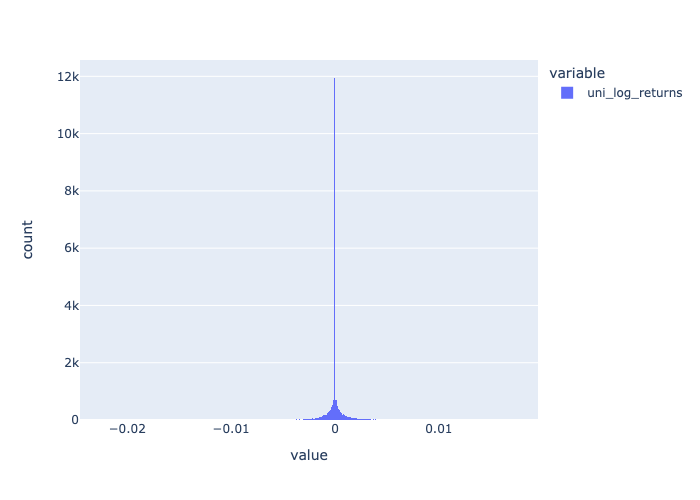

In [118]:
plt = px.histogram(df, x=['uni_log_returns'], nbins=500)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

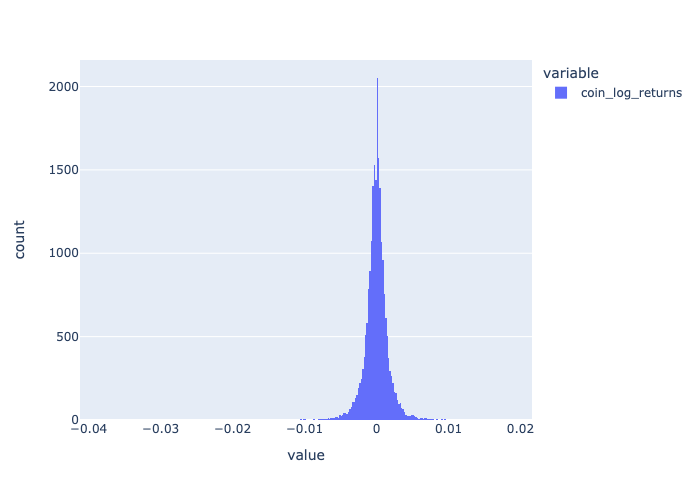

In [119]:
plt = px.histogram(df, x=['coin_log_returns'], nbins=500)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

Uni distribution has way too many zeros. Maybe pystable is not able to fit the distribution. Check qq plot

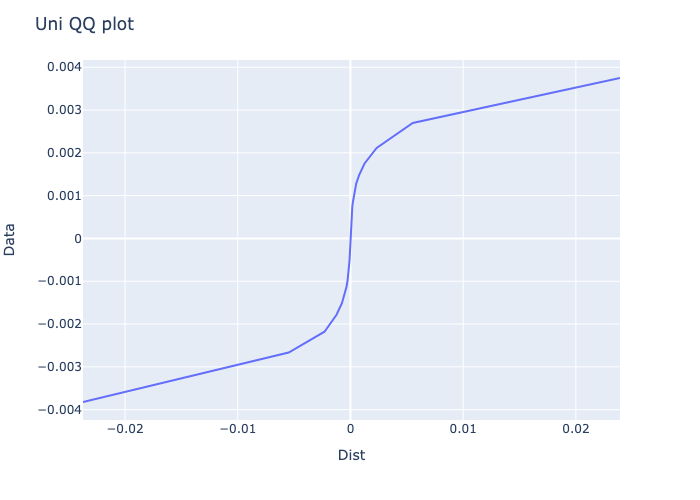

In [120]:
uni_q_data = get_qs_data(log_uni)
plt = line_chart(pd.DataFrame({'data': uni_q_data, 'dist': uni_q}), 'Uni QQ plot', 'dist', 'data', 'Dist', 'Data')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

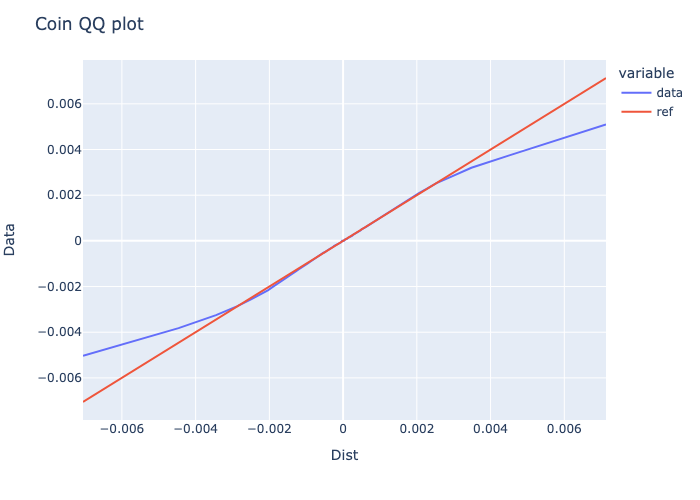

In [121]:
coin_q_data = get_qs_data(log_coin)
plt = line_chart(pd.DataFrame({'data': coin_q_data, 'dist': coin_q, 'ref': coin_q}),
                 'Coin QQ plot', 'dist', ['data','ref'], 'Dist', 'Data')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

# Try adding noise

In [122]:
noise_df = df.copy(deep=True)
noise_df = noise_df.iloc[1:,:]  # Remove first row since log returns are NA

In [123]:
noise_df

,time,coin,uni,uni_log_returns,coin_log_returns
1,2022-06-01 00:10:00,16.373312,16.345683,6.177501e-04,0.000573
2,2022-06-01 00:20:00,16.416318,16.351692,3.675261e-04,0.002623
3,2022-06-01 00:30:00,16.397475,16.361773,6.163437e-04,-0.001148
4,2022-06-01 00:40:00,16.388069,16.366600,2.949345e-04,-0.000574
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000e+00,-0.001556
...,...,...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307,0.000000e+00,-0.001692
21879,2022-10-30 22:30:00,12.997141,12.995306,-1.136248e-07,-0.000650
21880,2022-10-30 22:40:00,12.990387,12.995304,-1.136248e-07,-0.000520
21881,2022-10-30 22:50:00,12.971851,12.995304,0.000000e+00,-0.001428


In [124]:
# Found out the percentage difference between uniswap and coinbase prices
noise_df['uni_coin_diff'] = noise_df.uni/noise_df.coin - 1
noise_df

,time,coin,uni,uni_log_returns,coin_log_returns,uni_coin_diff
1,2022-06-01 00:10:00,16.373312,16.345683,6.177501e-04,0.000573,-0.001687
2,2022-06-01 00:20:00,16.416318,16.351692,3.675261e-04,0.002623,-0.003937
3,2022-06-01 00:30:00,16.397475,16.361773,6.163437e-04,-0.001148,-0.002177
4,2022-06-01 00:40:00,16.388069,16.366600,2.949345e-04,-0.000574,-0.001310
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000e+00,-0.001556,0.000245
...,...,...,...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307,0.000000e+00,-0.001692,-0.000791
21879,2022-10-30 22:30:00,12.997141,12.995306,-1.136248e-07,-0.000650,-0.000141
21880,2022-10-30 22:40:00,12.990387,12.995304,-1.136248e-07,-0.000520,0.000379
21881,2022-10-30 22:50:00,12.971851,12.995304,0.000000e+00,-0.001428,0.001808


In [125]:
# Average percentage price difference is expected to be ~0 since basically the prices are very similar
noise_df.uni_coin_diff.mean()

1.8854669752077555e-05

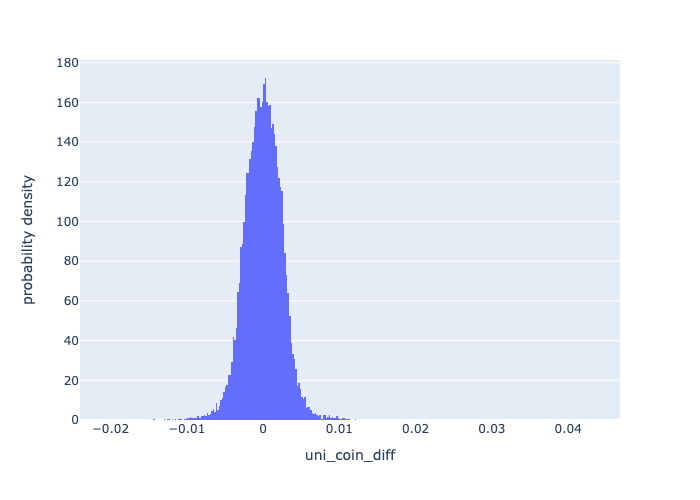

In [126]:
# Plot distribution of price difference. Expected to be gaussian
plt = px.histogram(noise_df, x='uni_coin_diff', nbins=500, histnorm='probability density')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [127]:
mean, std_dev = norm.fit(noise_df.uni_coin_diff)
print('Mean =', mean)
print('Std Dev =', std_dev)

Mean = 1.8854669752077555e-05
Std Dev = 0.0025371914816321155


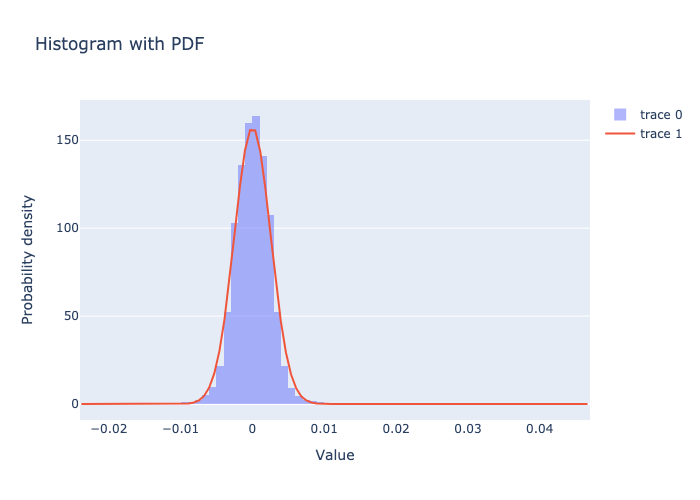

In [128]:
# plot the histogram of the data
histogram = go.Histogram(x=noise_df.uni_coin_diff, nbinsx=100, histnorm='probability density', opacity=0.5)
x = np.linspace(noise_df.uni_coin_diff.min(), noise_df.uni_coin_diff.max(), 100)
pdf = norm.pdf(x, loc=mean, scale=std_dev)
line = go.Scatter(x=x, y=pdf, mode='lines')
fig = go.Figure(data=[histogram, line])

# update the layout
fig.update_layout(title='Histogram with PDF', xaxis_title='Value', yaxis_title='Probability density')

# show the plot
fig.show() if interact_chart else Image(fig.to_image(format="png"))


In [129]:
def gauss_data_point(mean, stddev, thresh):
    lower_bound = mean - thresh*stddev
    upper_bound = mean + thresh*stddev
    point = np.random.normal(loc=mean, scale=std_dev, size=1)
    while (point < lower_bound) | (point > upper_bound):
        point = np.random.normal(loc=mean, scale=std_dev, size=1)
    return point[0]

### Add noise to all uni data points

In [130]:
noise_df['uni_noisy'] = noise_df.uni.apply(
    lambda x: (gauss_data_point(mean, std_dev, 2) + 1) * x
)

In [131]:
noise_df

,time,coin,uni,uni_log_returns,coin_log_returns,uni_coin_diff,uni_noisy
1,2022-06-01 00:10:00,16.373312,16.345683,6.177501e-04,0.000573,-0.001687,16.330805
2,2022-06-01 00:20:00,16.416318,16.351692,3.675261e-04,0.002623,-0.003937,16.378839
3,2022-06-01 00:30:00,16.397475,16.361773,6.163437e-04,-0.001148,-0.002177,16.400232
4,2022-06-01 00:40:00,16.388069,16.366600,2.949345e-04,-0.000574,-0.001310,16.363292
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000e+00,-0.001556,0.000245,16.382234
...,...,...,...,...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307,0.000000e+00,-0.001692,-0.000791,12.951624
21879,2022-10-30 22:30:00,12.997141,12.995306,-1.136248e-07,-0.000650,-0.000141,12.968662
21880,2022-10-30 22:40:00,12.990387,12.995304,-1.136248e-07,-0.000520,0.000379,12.957242
21881,2022-10-30 22:50:00,12.971851,12.995304,0.000000e+00,-0.001428,0.001808,13.005818


In [132]:
log_uni_noisy = log_returns(np.array(noise_df.uni_noisy))

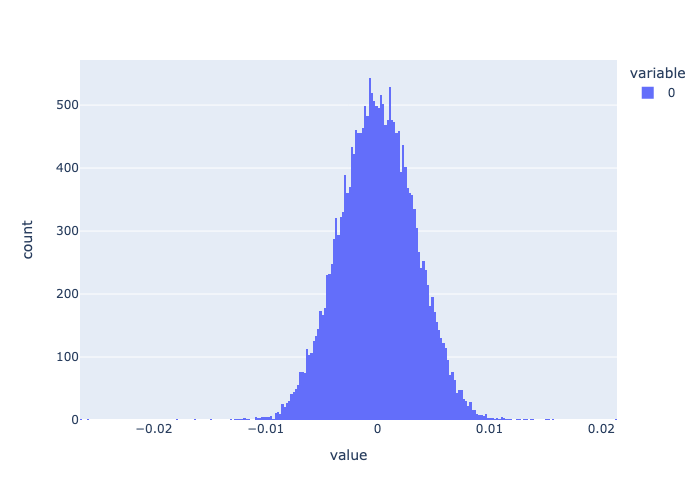

In [133]:
plt = px.histogram(log_uni_noisy)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

### Add noise to only those uni data points that are repeating

In [134]:
noise_df['shift_uni'] = noise_df.uni.shift(1)
noise_df['uni_noisy_v2'] = np.where(
    noise_df.uni == noise_df.shift_uni,
    noise_df.uni.apply(lambda x: (gauss_data_point(mean, std_dev, 2) + 1) * x),
    noise_df.uni
)

In [135]:
noise_df.head()

,time,coin,uni,uni_log_returns,coin_log_returns,uni_coin_diff,uni_noisy,shift_uni,uni_noisy_v2
1,2022-06-01 00:10:00,16.373312,16.345683,0.000618,0.000573,-0.001687,16.330805,NaN,16.345683
2,2022-06-01 00:20:00,16.416318,16.351692,0.000368,0.002623,-0.003937,16.378839,16.345683,16.351692
3,2022-06-01 00:30:00,16.397475,16.361773,0.000616,-0.001148,-0.002177,16.400232,16.351692,16.361773
4,2022-06-01 00:40:00,16.388069,16.366600,0.000295,-0.000574,-0.001310,16.363292,16.361773,16.366600
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000,-0.001556,0.000245,16.382234,16.366600,16.395573


In [136]:
log_uni_noisy_v2 = log_returns(np.array(noise_df.uni_noisy_v2))

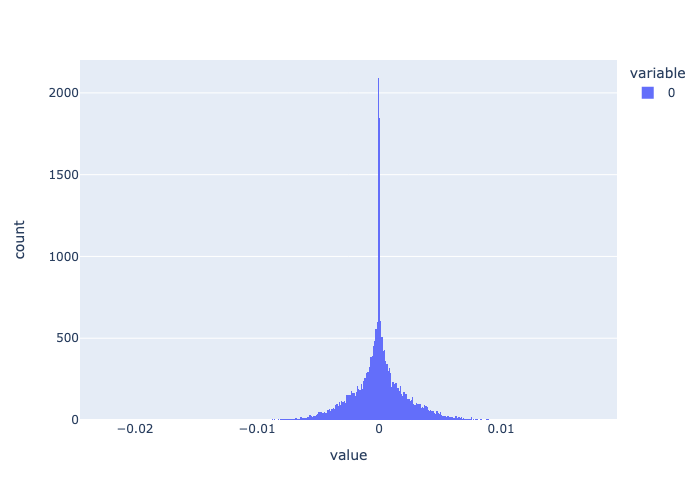

In [137]:
plt = px.histogram(log_uni_noisy_v2, nbins=500, labels='check')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [138]:
# Plot all histograms side by side
hist_df = pd.concat([
    df.coin_log_returns,
    df.uni_log_returns,
    pd.Series(log_uni_noisy),
    pd.Series(log_uni_noisy_v2)
], axis =1
)

hist_df.dropna(inplace=True)

hist_df.columns = ['Coinbase raw', 'Uniswap raw',
                   'Uniswap with noise',
                   'Uniswap with noise when no price change']

hist_df = pd.melt(hist_df, var_name='Log returns', value_name='Values')


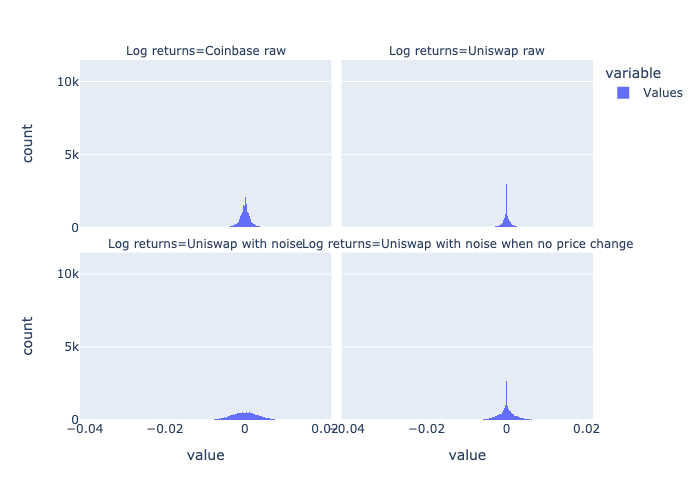

In [139]:
plt = px.histogram(hist_df, nbins=500, facet_col='Log returns', facet_col_wrap=2)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

#### Observations from adding noise
Experiment 1: Adding Gaussian noise to each uniswap price
Observation: Resulting distribution has fewer zeros, but a totally different distribution compared to the coinbase one.

Experiment 2: Adding Gaussin noise to only those uniswap prices which are the same as the previos price
Observation: Resulting distribution has idential amount of zeros! But the rest of the distribution is very different. And the difference is due to the fact that coinbase prices have smaller movements and therefore many points close to 0. While uniswap markets have relatively larger movements and therefore fewer points close to 0.

#### Learnings

1. Using 10-minute intervals for data collection from Uniswap is not recommended as the price doesn't change frequently enough to warrant such short intervals. However, a 10-minute interval is justified for risk analysis of Coinbase prices, which do see changes every 10 minutes or so. To understand things better with the help of an extreme example - try to imagine the problem with collecting prices from coinbase every nanosecond. That will also result in many zeros if you take log returns. And it doesn't make sense anyway because people don't trade that frequently on coinbase. By the same logic, we shouldn't collect data every 10 minutes from Uniswap either, since prices don't change that frequently.

2. There seems to be a relationship between the number of zeros in the data and the range of the distribution fitting that data. This relationship should be explored

In [140]:
# Data manipulation funcs

def set_periodicity(df, time_col, price_col, tf):
    df.index = df[time_col]
    df = df[[price_col]]
    df = df.resample(f"{tf}S").ohlc()
    df = df[price_col][[price_col]]
    df.reset_index(inplace=True)
    df.close.ffill(inplace=True)
    return df


def twap(df, time_col, price_col, tf):
    df.set_index(time_col, inplace=True)
    df = df[[price_col]]
    df = df.rolling(f'{tf}s', min_periods=1).mean()
    df.reset_index(inplace=True)
    return df

def change_interval(df, time_col, price_col, tf):
    df = df.copy(deep=True)
    df = twap(df, time_col, price_col, tf)
    df = set_periodicity(df, time_col, price_col, tf)
    return df


In [141]:
# Read spot uniswap ETH-BTC data
uni_spot = pd.read_csv('../csv/WBTC-WETH-SPOT-14881677-to-15864319.csv', index_col=0)
uni_spot['timestamp'] = pd.to_datetime(uni_spot['timestamp'])
uni_spot = set_periodicity(uni_spot, 'timestamp', 'close', 10)  # Convert uniswap data to 10 secs
uni_spot

,timestamp,close
0,2022-06-01 00:01:50,16.335589
1,2022-06-01 00:02:00,16.335589
2,2022-06-01 00:02:10,16.335589
3,2022-06-01 00:02:20,16.335589
4,2022-06-01 00:02:30,16.335589
...,...,...
1312951,2022-10-30 23:07:00,12.995307
1312952,2022-10-30 23:07:10,12.995307
1312953,2022-10-30 23:07:20,12.995307
1312954,2022-10-30 23:07:30,12.995307


In [142]:
# Get multiple dfs with different 10, 15, 20, ... min time intervals
dfs = []
step_rng = range(900, 7200, 300)
for i in step_rng:
    dfs.append(change_interval(uni_spot, 'timestamp', 'close', i))

In [143]:
# Get number of zeros for each df
lrs = []
for i in range(len(dfs)):
    lrs.append(log_returns(dfs[i].close))

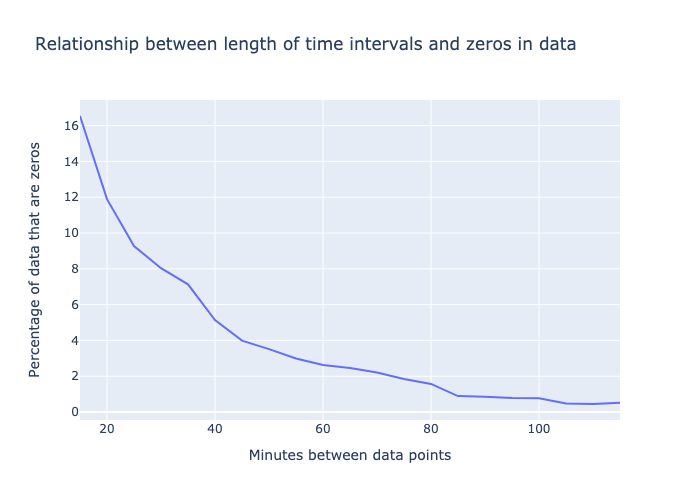

In [144]:
# Count the number of zeros in each sublist of log returns
zero_counts = [(sublist.count(0)/len(sublist))*100 for sublist in lrs]

plt = px.line(
    x=[i/60 for i in list(step_rng)],
    y=zero_counts,
    labels={'x': 'Minutes between data points', 'y': 'Percentage of data that are zeros'},
    title='Relationship between length of time intervals and zeros in data'
)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [145]:
# Percentage of zeros in coinbase data
(sum(1 for value in log_coin if -0.0002 < value < 0.0002)/len(log_coin)) * 100

15.940042043688877

In [146]:
# Get init gaussian dists
dsts = []
for i in range(len(step_rng)):
    dsts.append(gaussian())

In [147]:
# Fit stable dists
for i in range(len(step_rng)):
    pystable.fit(dsts[i], lrs[i], len(lrs[i]))

In [148]:
# Get ranges
dist_range = []
for i in range(len(step_rng)):
    qs = get_qs(dsts[i])
    dist_range.append(
        qs[-1] - qs[0]
    )

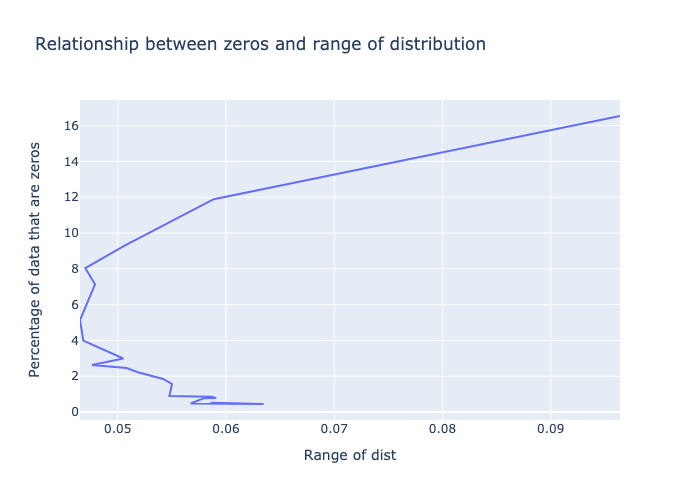

In [149]:
plt = px.line(
    x=dist_range,
    y=zero_counts,
    labels={'x': 'Range of dist', 'y': 'Percentage of data that are zeros'},
    title='Relationship between zeros and range of distribution'
)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

Choose one  of the points on the left where the range is small and there are fewer zeros in data.

Range = 0.0467

Percentage of data that are zeros = 2.63%

That is, 60 min data

In [150]:
# Get 60 min data
uni_df_t = change_interval(uni_spot, 'timestamp', 'close', 3600)
uni_df_t

,timestamp,close
0,2022-06-01 00:00:00,16.356108
1,2022-06-01 01:00:00,16.366195
2,2022-06-01 02:00:00,16.382091
3,2022-06-01 03:00:00,16.388642
4,2022-06-01 04:00:00,16.388642
...,...,...
3643,2022-10-30 19:00:00,13.012910
3644,2022-10-30 20:00:00,13.011992
3645,2022-10-30 21:00:00,12.996194
3646,2022-10-30 22:00:00,12.995291


In [151]:
log_uni_t = log_returns(uni_df_t.close)

In [152]:
dst_uni_t = gaussian()
pystable.fit(dst_uni_t, log_uni_t, len(log_uni_t))

0

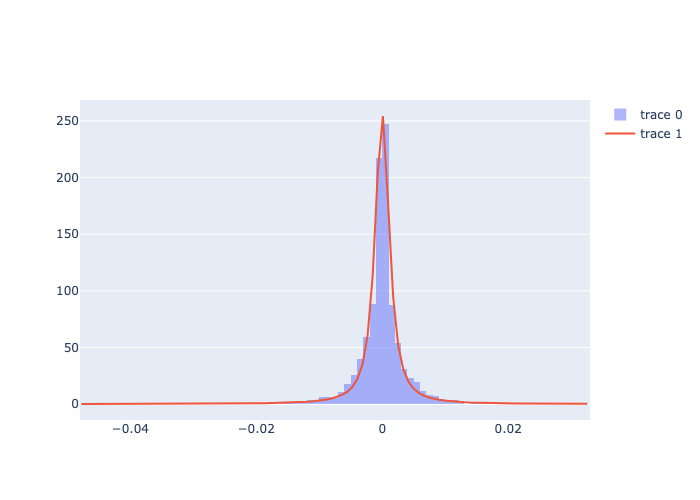

In [153]:
x = np.linspace(min(log_uni_t), max(log_uni_t), 100)
pdf_vals = pystable.pdf(dst_uni_t, x, len(x))

histogram = go.Histogram(x=log_uni_t, nbinsx=100, histnorm='probability density', opacity=0.5)
line = go.Scatter(x=x, y=pdf_vals, mode='lines')
plt = go.Figure(data=[histogram, line])
plt.show() if interact_chart else Image(plt.to_image(format="png"))

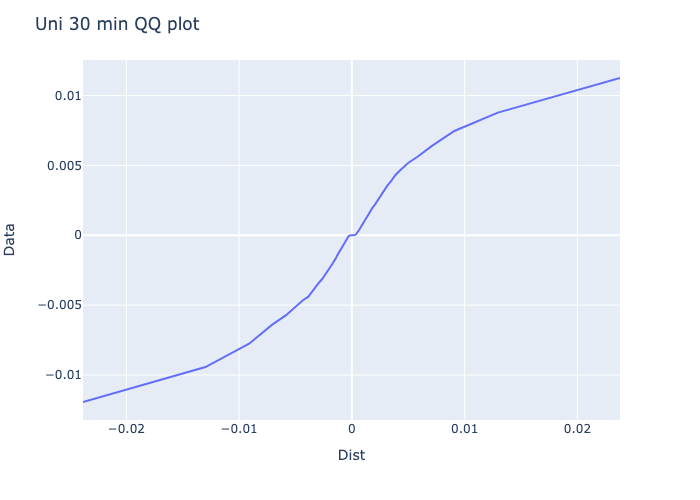

In [154]:
uni_q_data_t = get_qs_data(log_uni_t)
uni_q_t = get_qs(dst_uni_t)
plt = line_chart(pd.DataFrame({'data': uni_q_data_t, 'dist': uni_q_t}),
                 'Uni 30 min QQ plot', 'dist', 'data', 'Dist', 'Data')
plt.show() if interact_chart else Image(plt.to_image(format="png"))